# فاز 1

##  بارگذاری دیتاست

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # چون ResNet18 ورودی 224x224 می‌خواد
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])  # نرمال‌سازی استاندارد برای مدل‌های pretrained
])
dataset_path = "/content/drive/MyDrive/dataset3"
dataset = ImageFolder(root=dataset_path, transform=transform)
class_names = dataset.classes
print("Classes:", class_names)

# تقسیم train و test
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42, stratify=dataset.targets)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


Classes: ['cats', 'dogs', 'horses']


## تعریف مدل ResNet18 و استخراج لایه‌ها

In [ ]:
import torch.nn as nn
from torchvision import models

# بارگذاری ResNet18 pretrained
resnet = models.resnet18(pretrained=True)

# بدون نیاز به grad چون feature extractor هست
for param in resnet.parameters():
    param.requires_grad = False

# استخراج سه نوع ویژگی:
# 1. ویژگی‌های ابتدایی: تا maxpool
features_low = nn.Sequential(
    resnet.conv1,
    resnet.bn1,
    resnet.relu,
    resnet.maxpool
)

# 2. ویژگی‌های میانی: تا layer2
features_mid = nn.Sequential(
    features_low,
    resnet.layer1,
    resnet.layer2
)

# 3. ویژگی‌های سطح بالا: تا avgpool
features_high = nn.Sequential(
    features_mid,
    resnet.layer3,
    resnet.layer4,
    resnet.avgpool
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
features_low = features_low.to(device)
features_mid = features_mid.to(device)
features_high = features_high.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## تابع استخراج ویژگی

In [ ]:
!pip install tqdm


In [ ]:
from tqdm import tqdm

def extract_features(dataloader, feature_extractor):
    features = []
    labels = []
    feature_extractor.eval()

    with torch.no_grad():
        for images, lbls in tqdm(dataloader, desc="Extracting Features"):
            images = images.to(device)
            outputs = feature_extractor(images)
            outputs = outputs.view(outputs.size(0), -1)
            features.append(outputs.cpu().numpy())
            labels.append(lbls.numpy())

    X = np.concatenate(features, axis=0)
    y = np.concatenate(labels, axis=0)
    return X, y


In [ ]:
X_low, y_low = extract_features(train_loader, features_low)
X_mid, y_mid = extract_features(train_loader, features_mid)
X_high, y_high = extract_features(train_loader, features_high)


Extracting Features: 100%|██████████| 16/16 [00:00<00:00, 29.34it/s]


## آموزش مدل‌های طبقه‌بندی و نتایج هرکدام

In [ ]:
# توابع نمایش تحلیل

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

def show_confusion_matrix_fixed(y_true, y_pred, class_names, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title(title)
    plt.grid(False)
    plt.show()

def classification_metrics_fixed(y_true, y_pred, class_names):
    print("\n")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm


# تابع آموزش و نمایش نتایج
def evaluate_models_detailed(X, y, class_names, title=""):
    from sklearn.svm import SVC
    from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import GaussianNB

    models = {
        "SVM": SVC(probability=True),
        "KNN": KNeighborsClassifier(),
        "Random Forest": RandomForestClassifier(),
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Extra Trees": ExtraTreesClassifier(),
        "Gaussian NB": GaussianNB()
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = {}

    print(f"\n🔍 Evaluation for: {title}\n{'-'*50}")

    for name, model in models.items():
        accuracies, precisions, recalls, f1s = [], [], [], []
        all_y_true, all_y_pred = [], []

        print(f"\nEvaluating {name}...")
        for train_idx, test_idx in tqdm(cv.split(X, y), total=cv.get_n_splits(), desc=f"{name} CV folds"):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            all_y_true.extend(y_test)
            all_y_pred.extend(y_pred)

            accuracies.append(accuracy_score(y_test, y_pred))
            precisions.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
            recalls.append(recall_score(y_test, y_pred, average='weighted', zero_division=0))
            f1s.append(f1_score(y_test, y_pred, average='weighted', zero_division=0))

        # ذخیره نتایج
        results[name] = {
            "accuracy_mean": np.mean(accuracies),
            "accuracy_std": np.std(accuracies),
            "precision_mean": np.mean(precisions),
            "recall_mean": np.mean(recalls),
            "f1_mean": np.mean(f1s),
            "y_true": all_y_true,
            "y_pred": all_y_pred
        }

        # نمایش گزارش متنی و ماتریس
        classification_metrics_fixed(all_y_true, all_y_pred, class_names)
        show_confusion_matrix_fixed(all_y_true, all_y_pred, class_names, title=f"Confusion Matrix - {name}")

    # انتخاب بهترین مدل بر اساس دقت
    best_model = max(results.items(), key=lambda x: x[1]['accuracy_mean'])
    print(f"\n🏆 Best model based on Accuracy: **{best_model[0]}** with Accuracy = {best_model[1]['accuracy_mean']:.4f}")

    return results


### ویژگی های ابتدایی


🔍 Evaluation for: Low-Level Features
--------------------------------------------------

Evaluating SVM...


SVM CV folds: 100%|██████████| 5/5 [20:23<00:00, 244.70s/it]



              precision    recall  f1-score   support

        cats       0.57      0.80      0.67       162
        dogs       0.61      0.45      0.51       161
      horses       0.88      0.76      0.82       161

    accuracy                           0.67       484
   macro avg       0.69      0.67      0.67       484
weighted avg       0.69      0.67      0.67       484



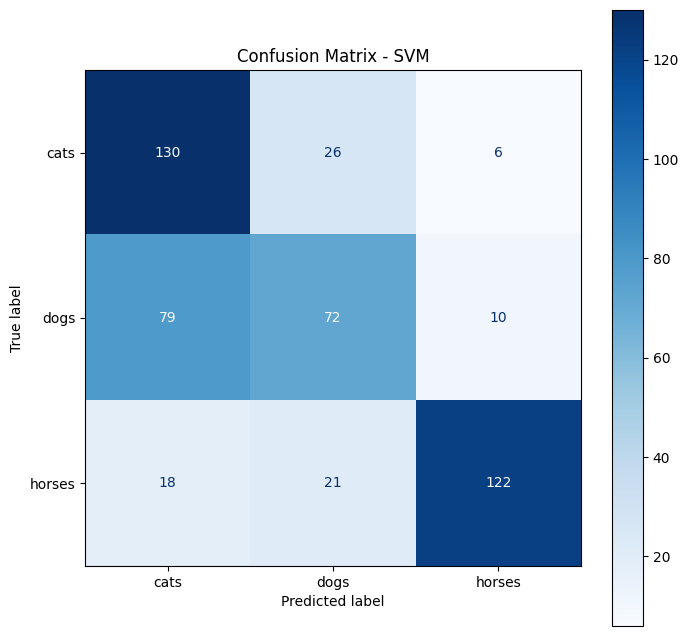


Evaluating KNN...


KNN CV folds: 100%|██████████| 5/5 [00:06<00:00,  1.23s/it]




              precision    recall  f1-score   support

        cats       0.41      0.84      0.55       162
        dogs       0.53      0.32      0.40       161
      horses       0.88      0.31      0.46       161

    accuracy                           0.49       484
   macro avg       0.61      0.49      0.47       484
weighted avg       0.61      0.49      0.47       484



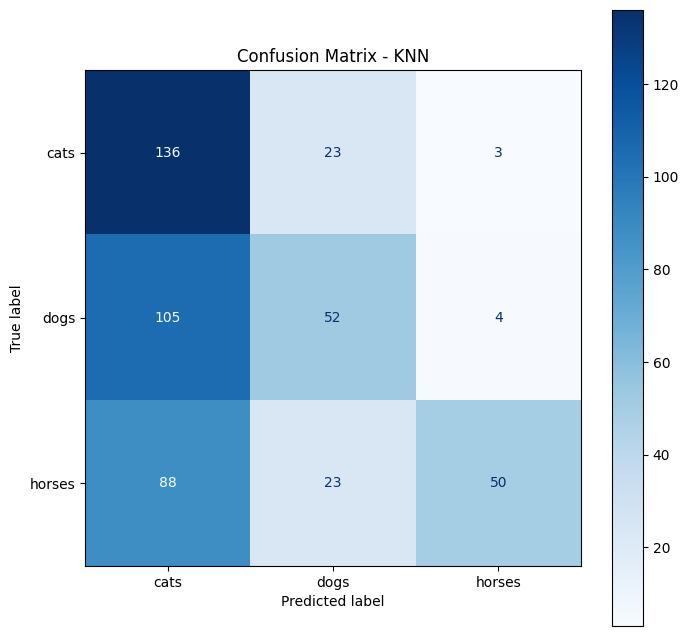


Evaluating Random Forest...


Random Forest CV folds: 100%|██████████| 5/5 [00:40<00:00,  8.03s/it]




              precision    recall  f1-score   support

        cats       0.63      0.77      0.69       162
        dogs       0.63      0.52      0.57       161
      horses       0.83      0.80      0.81       161

    accuracy                           0.69       484
   macro avg       0.70      0.69      0.69       484
weighted avg       0.70      0.69      0.69       484



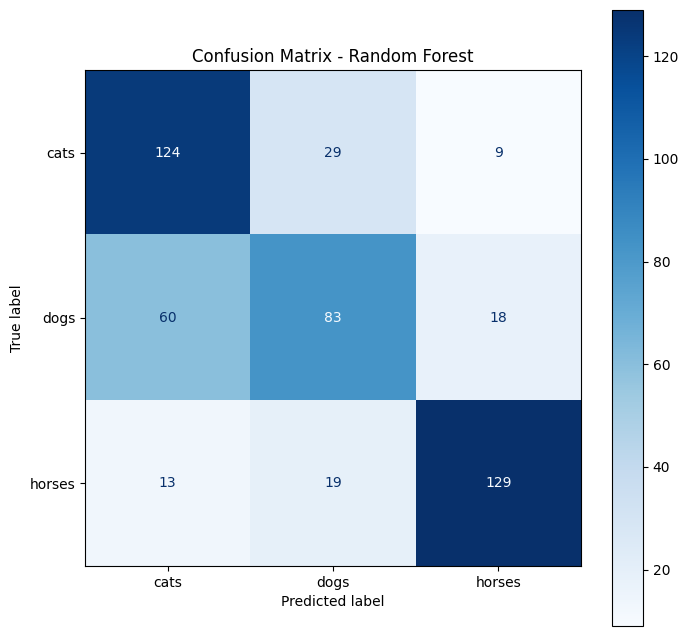


Evaluating Logistic Regression...


Logistic Regression CV folds: 100%|██████████| 5/5 [02:10<00:00, 26.10s/it]



              precision    recall  f1-score   support

        cats       0.64      0.75      0.69       162
        dogs       0.67      0.54      0.60       161
      horses       0.81      0.83      0.82       161

    accuracy                           0.70       484
   macro avg       0.71      0.70      0.70       484
weighted avg       0.71      0.70      0.70       484



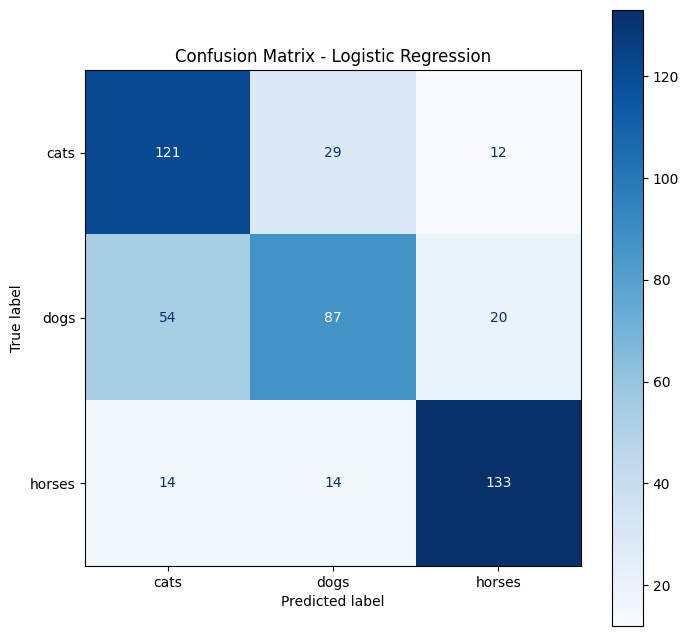


Evaluating Extra Trees...


Extra Trees CV folds: 100%|██████████| 5/5 [00:17<00:00,  3.44s/it]



              precision    recall  f1-score   support

        cats       0.62      0.74      0.68       162
        dogs       0.61      0.52      0.56       161
      horses       0.83      0.81      0.82       161

    accuracy                           0.69       484
   macro avg       0.69      0.69      0.69       484
weighted avg       0.69      0.69      0.69       484



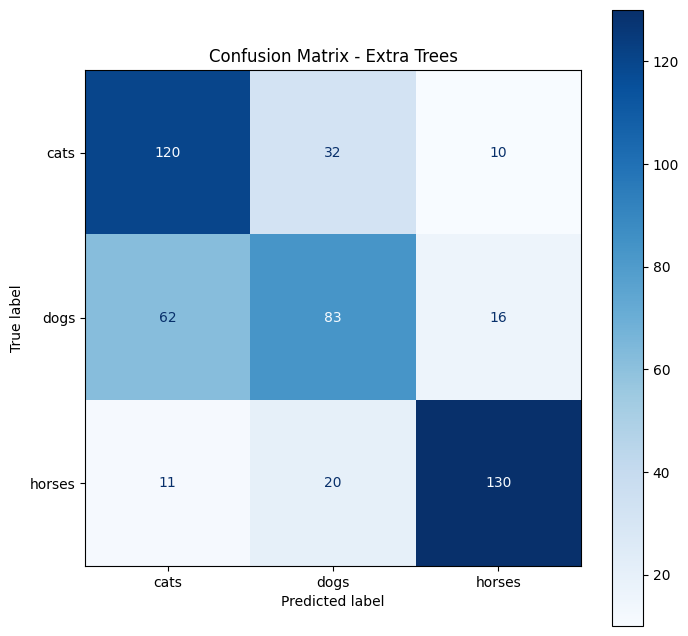


Evaluating Gaussian NB...


Gaussian NB CV folds: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]



              precision    recall  f1-score   support

        cats       0.57      0.68      0.62       162
        dogs       0.51      0.47      0.49       161
      horses       0.77      0.68      0.72       161

    accuracy                           0.61       484
   macro avg       0.62      0.61      0.61       484
weighted avg       0.62      0.61      0.61       484



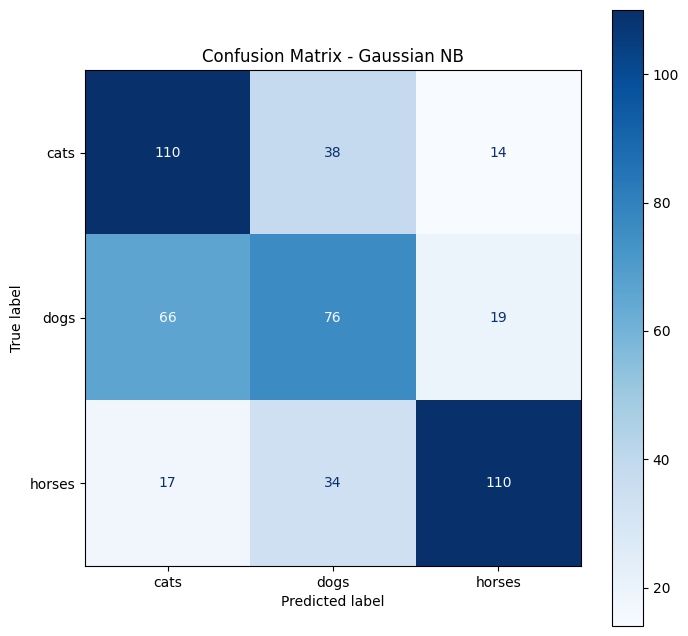


🏆 Best model based on Accuracy: **Logistic Regression** with Accuracy = 0.7045


In [ ]:
results_low = evaluate_models_detailed(X_low, y_low, class_names, "Low-Level Features")

### ویژگی های میانی


🔍 Evaluation for: Mid-Level Features
--------------------------------------------------

Evaluating SVM...


SVM CV folds: 100%|██████████| 5/5 [11:14<00:00, 134.84s/it]



              precision    recall  f1-score   support

        cats       0.75      0.81      0.78       162
        dogs       0.70      0.74      0.72       161
      horses       0.97      0.82      0.89       161

    accuracy                           0.79       484
   macro avg       0.80      0.79      0.79       484
weighted avg       0.80      0.79      0.79       484



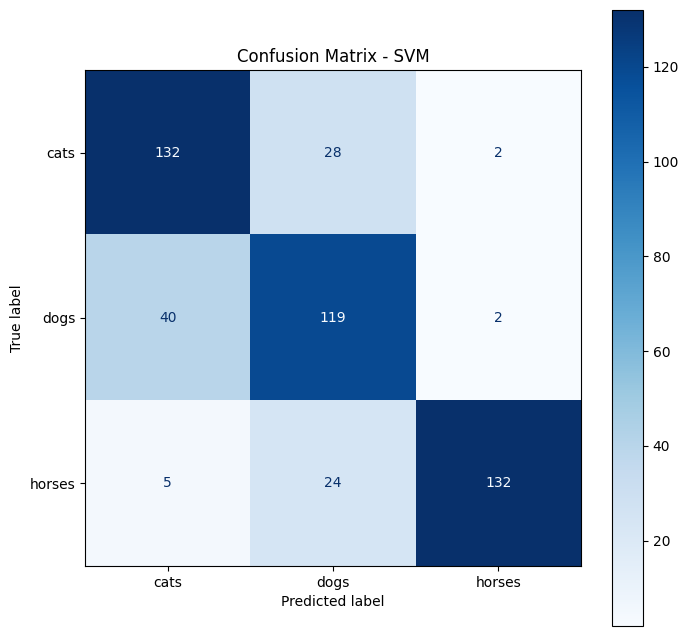


Evaluating KNN...


KNN CV folds: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]



              precision    recall  f1-score   support

        cats       0.49      0.23      0.31       162
        dogs       0.46      0.41      0.43       161
      horses       0.47      0.78      0.59       161

    accuracy                           0.47       484
   macro avg       0.47      0.47      0.44       484
weighted avg       0.47      0.47      0.44       484



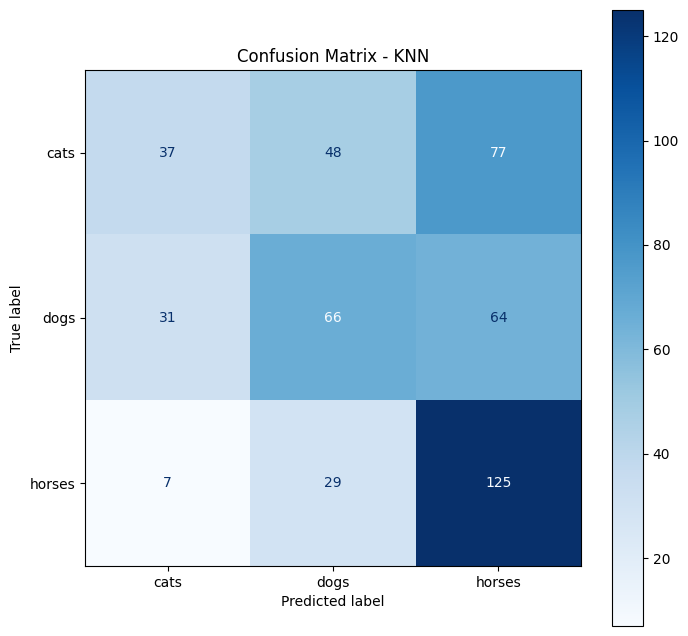


Evaluating Random Forest...


Random Forest CV folds: 100%|██████████| 5/5 [00:20<00:00,  4.17s/it]




              precision    recall  f1-score   support

        cats       0.58      0.67      0.62       162
        dogs       0.60      0.55      0.58       161
      horses       0.86      0.79      0.82       161

    accuracy                           0.67       484
   macro avg       0.68      0.67      0.67       484
weighted avg       0.68      0.67      0.67       484



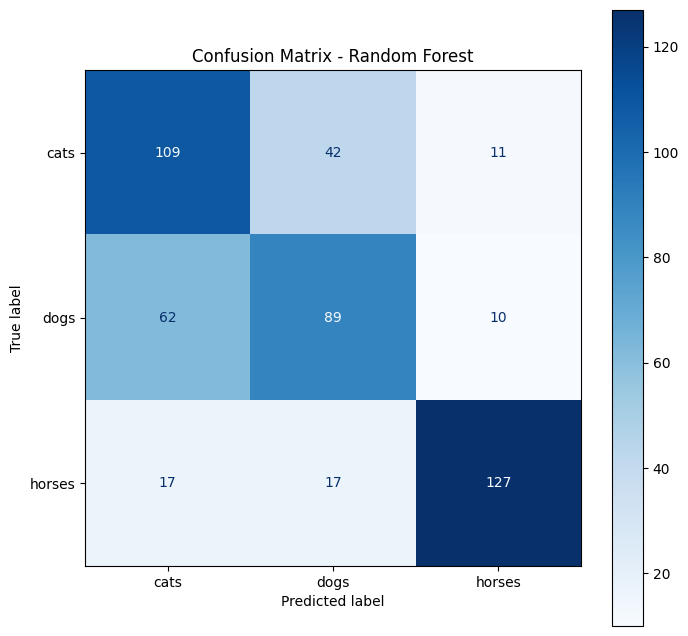


Evaluating Logistic Regression...


Logistic Regression CV folds: 100%|██████████| 5/5 [00:35<00:00,  7.03s/it]



              precision    recall  f1-score   support

        cats       0.78      0.88      0.83       162
        dogs       0.79      0.72      0.75       161
      horses       0.94      0.91      0.93       161

    accuracy                           0.84       484
   macro avg       0.84      0.84      0.84       484
weighted avg       0.84      0.84      0.84       484



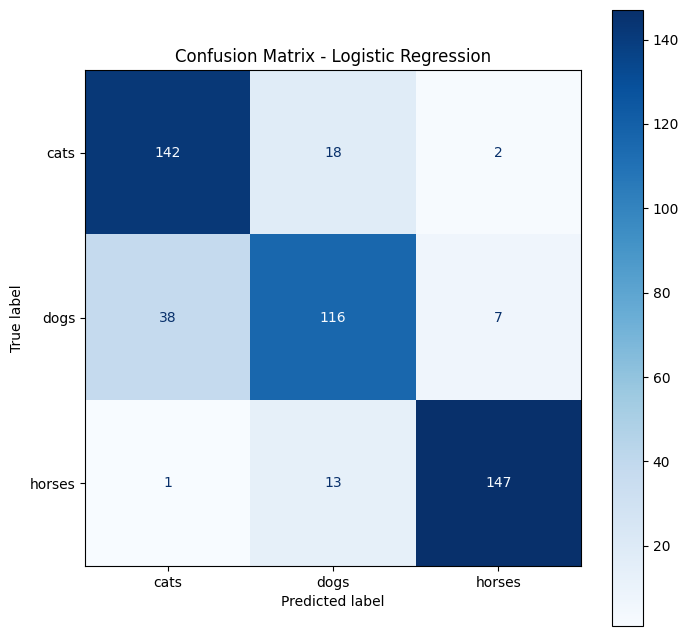


Evaluating Extra Trees...


Extra Trees CV folds: 100%|██████████| 5/5 [00:11<00:00,  2.29s/it]



              precision    recall  f1-score   support

        cats       0.60      0.69      0.64       162
        dogs       0.62      0.60      0.61       161
      horses       0.91      0.80      0.85       161

    accuracy                           0.69       484
   macro avg       0.71      0.69      0.70       484
weighted avg       0.71      0.69      0.70       484



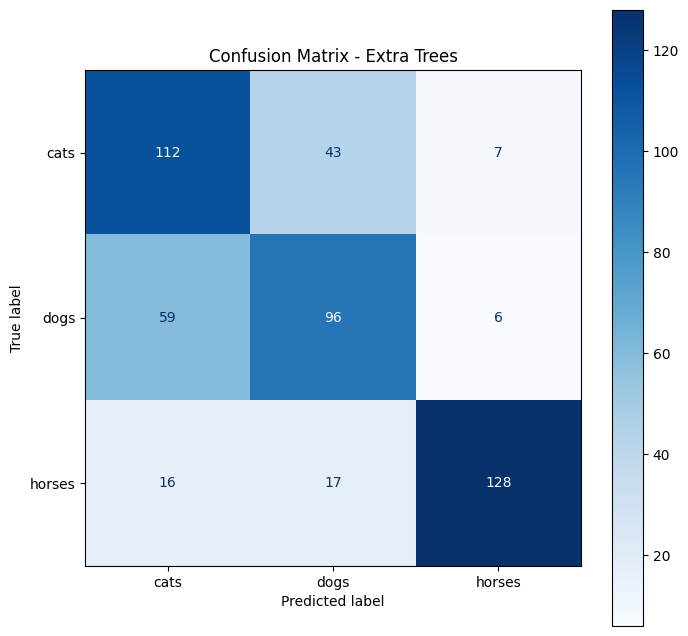


Evaluating Gaussian NB...


Gaussian NB CV folds: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]



              precision    recall  f1-score   support

        cats       0.77      0.61      0.68       162
        dogs       0.55      0.81      0.65       161
      horses       0.93      0.69      0.79       161

    accuracy                           0.70       484
   macro avg       0.75      0.70      0.71       484
weighted avg       0.75      0.70      0.71       484



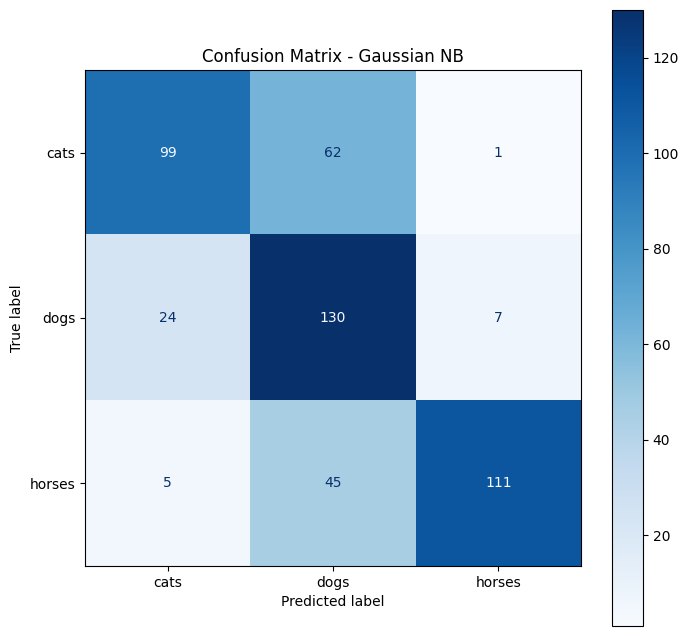


🏆 Best model based on Accuracy: **Logistic Regression** with Accuracy = 0.8368


In [15]:
results_mid = evaluate_models_detailed(X_mid, y_mid, class_names, "Mid-Level Features")

### ویژگی های سطح بالا


🔍 Evaluation for: High-Level Features
--------------------------------------------------

Evaluating SVM...


SVM CV folds: 100%|██████████| 5/5 [00:00<00:00,  7.22it/s]




              precision    recall  f1-score   support

        cats       0.98      0.94      0.96       162
        dogs       0.95      0.98      0.96       161
      horses       1.00      1.00      1.00       161

    accuracy                           0.98       484
   macro avg       0.98      0.98      0.98       484
weighted avg       0.98      0.98      0.98       484



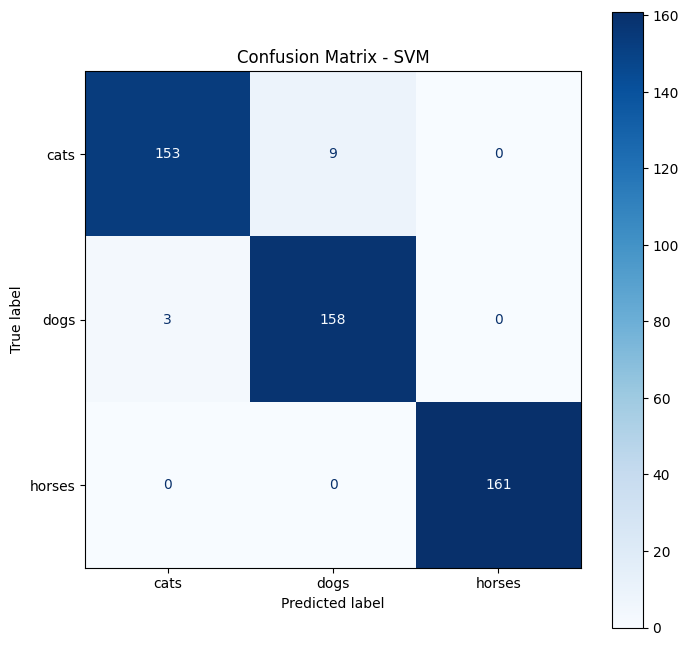


Evaluating KNN...


KNN CV folds: 100%|██████████| 5/5 [00:00<00:00, 110.57it/s]



              precision    recall  f1-score   support

        cats       0.96      0.96      0.96       162
        dogs       0.96      0.94      0.95       161
      horses       0.99      1.00      0.99       161

    accuracy                           0.97       484
   macro avg       0.97      0.97      0.97       484
weighted avg       0.97      0.97      0.97       484



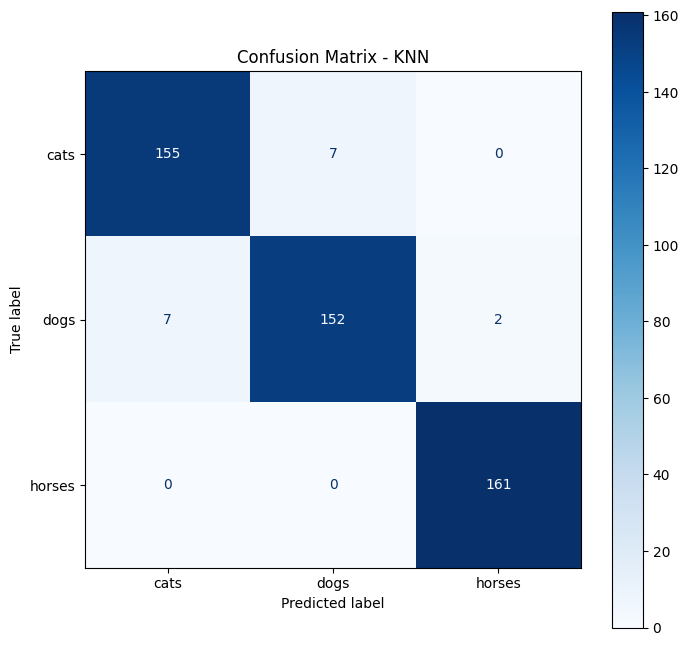


Evaluating Random Forest...


Random Forest CV folds: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]



              precision    recall  f1-score   support

        cats       0.99      0.94      0.96       162
        dogs       0.93      0.98      0.95       161
      horses       0.99      0.99      0.99       161

    accuracy                           0.97       484
   macro avg       0.97      0.97      0.97       484
weighted avg       0.97      0.97      0.97       484



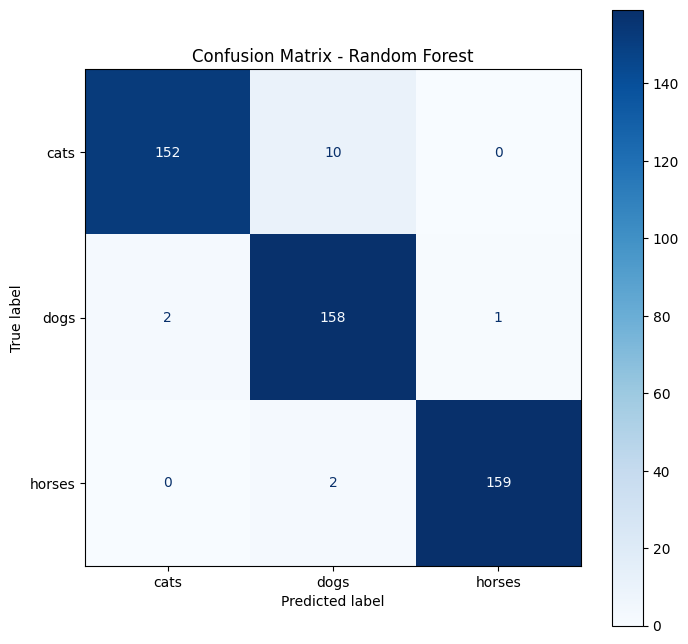


Evaluating Logistic Regression...


Logistic Regression CV folds: 100%|██████████| 5/5 [00:01<00:00,  4.17it/s]




              precision    recall  f1-score   support

        cats       0.97      0.97      0.97       162
        dogs       0.97      0.97      0.97       161
      horses       1.00      1.00      1.00       161

    accuracy                           0.98       484
   macro avg       0.98      0.98      0.98       484
weighted avg       0.98      0.98      0.98       484



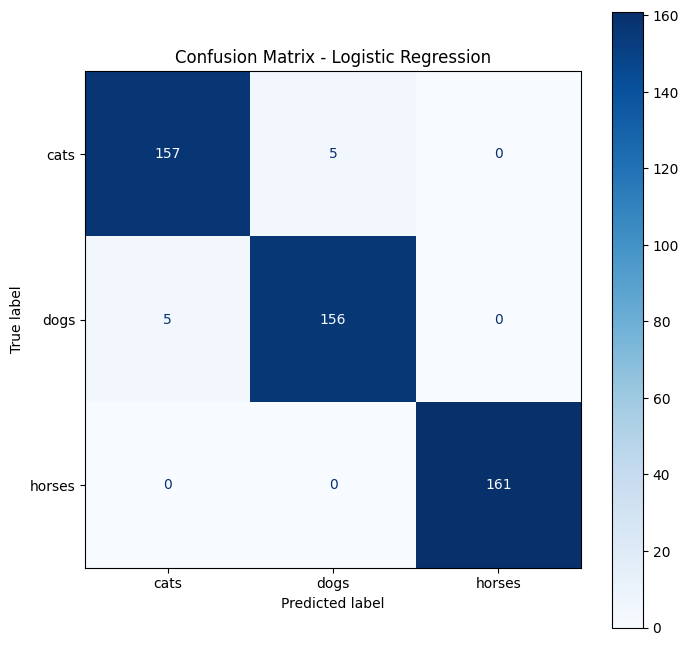


Evaluating Extra Trees...


Extra Trees CV folds: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]




              precision    recall  f1-score   support

        cats       0.99      0.94      0.97       162
        dogs       0.94      0.99      0.96       161
      horses       0.99      1.00      1.00       161

    accuracy                           0.98       484
   macro avg       0.98      0.98      0.98       484
weighted avg       0.98      0.98      0.98       484



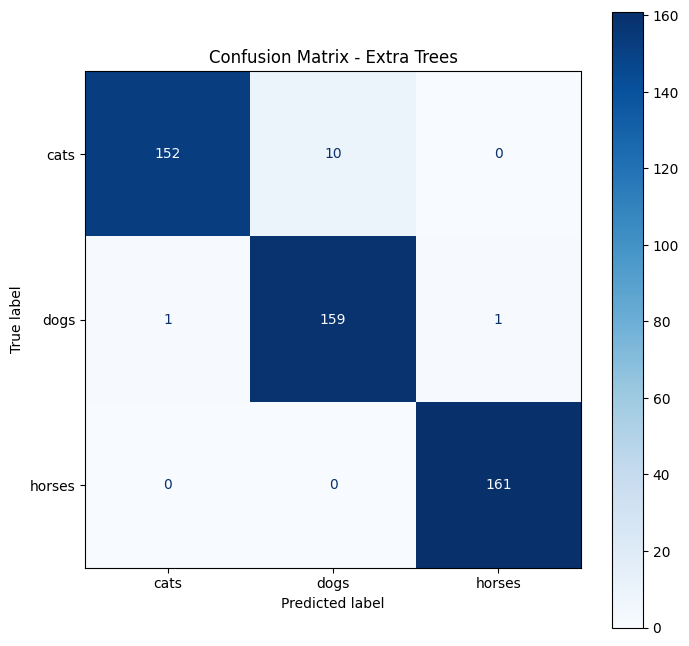


Evaluating Gaussian NB...


Gaussian NB CV folds: 100%|██████████| 5/5 [00:00<00:00, 21.80it/s]




              precision    recall  f1-score   support

        cats       0.99      0.92      0.95       162
        dogs       0.92      0.99      0.95       161
      horses       1.00      1.00      1.00       161

    accuracy                           0.97       484
   macro avg       0.97      0.97      0.97       484
weighted avg       0.97      0.97      0.97       484



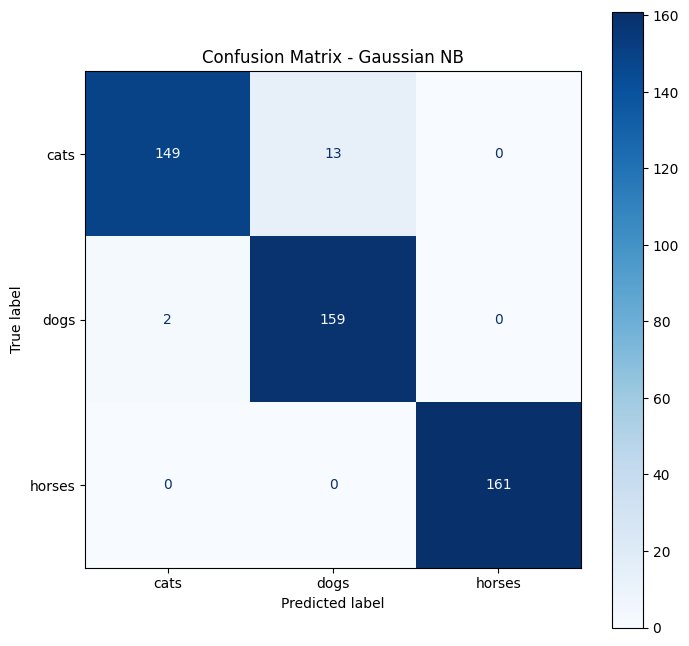


🏆 Best model based on Accuracy: **Logistic Regression** with Accuracy = 0.9793


In [16]:
results_high = evaluate_models_detailed(X_high, y_high, class_names, "High-Level Features")